# Stereovision

![Suzanne](main.png)

Stereovision is a discipline that deals with the reconstruction of 3D information from images. For the reconstruction of a point, several images of this point are needed. These images must be taken from different points of view. The key step of the reconstruction, which is often problematic, is to identify the images of the point to be reconstructed in each view.

## Epipolar Geometry

Epipolar geometry involves two cameras. The epipolar geometry describes the geometric properties between two views of the same scene and depends only on the intrinsic parameters of the cameras and their relative positions. It provides, in particular, the epipolar constraint, which will be very useful to produce the matches between views.

## The Fondamental Matrix

![Epipolar Geometry - Sanyam Kapoor](epipolar.png)

Let us imagine that we have two images, right and left, of the world space. Let's take a point $\vec{x}$ in the right image space. The point $\vec{X}$ of the world space, of which $\vec{x}$ is the image, can be anywhere on the line passing through $\vec{x}$ and the optical center of the right camera. We will call this line the back-projected ray of $\vec{x}$. Let us note $\vec{x}'$ the image of $\vec{X}$ in the left image space. The locus of $\vec{x}'$ is therefore the image line of the back-projected ray of $\vec{x}$. This line is called the epipolar line and is denoted $\vec{l}'$. The epipolar line passes through the epipole $\vec{e}'$, image of the optical center of the right camera.

In 2D projective geometry, a line with equation $ax+by+c = 0$ is represented by a vector with three components $(a, b, c)^T$ defined to within one factor. Thus, we have the following relationship:

>The point $\vec{x}$ belongs to the line $\vec{l}$ if and only if $x^T\vec{l} = 0$.

Moreover, in 2D projective geometry, the following remarkable relations are valid:

- The intersection of two lines $l$ and $l'$ is given by $x = l \times l'$,
- The line passing through two points $x$ and $x'$ is given by $l = x \times x'$.

Note that the vector product can be written as a product of matrix $x \times y = [x]_\times y$ where

$$[x]_\times = \begin{pmatrix} 0 & −x3 & x2 \\ x3 & 0 & −x1 \\ −x2 & x1 & 0 \end{pmatrix}$$

To find the equation of the epipolar line in the left image space, we just need to find the coordinates of two points of this line. The first is the image $P'\vec{C}$ of the optical center $\vec{C}$ of the right camera where $P'$ is the projection matrix of the left camera. The second is $P'P^{+}\vec{x}$ where $P^{+}$ is the pseudo inverse of the projection matrix $P$ of the right camera. The epipolar line thus has the equation $l' = [P'\vec{C}]_\times{}P'P^{+}\vec{x} = F\vec{x}$ with $F = [P'\vec{C}]_\times{}P'P^{+}$. $F$ is called fundamental matrix.

Since the epipolar line $\vec{l}' = F\vec{x}$ is the locus of $\vec{x}'$, $\vec{x}'$ therefore belongs to $\vec{l}'$ which leads to the epipolar constraint :

>**The fundamental matrix is such that for any pair of points corresponding $\vec{x} \leftrightarrow \vec{x}'$ in the two images, we have $\vec{x}'^{T}F\vec{x} = 0$.**

## Computation of the fundamental matrix

The fundamental matrix $F$ has seven degrees of freedom. It has nine components but these are defined to within one scale factor, which removes one degree of freedom. Moreover, the matrix $F$ is a singular matrix ($det(F) = 0$) which gives us seven degrees of freedom. So we need at least seven correspondences to compute $F$. The equation $x'^{T}_iFx_i = 0$ and the seven correspondences allow us to write a system of equations of the form $Af = 0$, where $f$ is the vector which contains the components of the matrix $F$. Let us assume that $A$ is a 7×9 matrix of rank 7. The general solution of $Af = 0$ can be written $\alpha f_1 + (1-\alpha) f_2$ where $f_1$ and $f_2$ are two particular independent solutions of $Af = 0$. We then use the singularity constraint $det(\alpha F_1 + (1 - \alpha)F_2) = 0$ to determine $\alpha$. Since the singularity constraint gives rise to a third degree equation, we may have one or three solutions for $F$.

## OpenCV

In practice you will use the OpenCV library. In python, you have access to its functions through the `cv2` module.

You can find help with the calibration and reconstruction functions on the site https://docs.opencv.org/4.0.0/d9/d0c/group__calib3d.html

## Goal

In the zip of the statement you will find two sequences of images taken by two cameras during the scanning of an object by a laser plane.

![Laser](scanRight/scan0010.png)

You will also find shots of a checkerboard in different positions that will help you calibrate your cameras.

![Damier](chessboards/c2Right.png)

The goal is to reconstruct the scanned object in 3D.

Recherche de damiers dans 'chessboards'...
Taille ytouve: (7, 7)
Calibration reussie 6 images.

--- Matrice Fondamentale (F) ---
[[ 0.          0.          0.00571527]
 [ 0.          0.          0.        ]
 [-0.00571527  0.          0.        ]]
Vérification épipolaire (Erreur doit être proche de 0) : 0.00000
--------------------------------



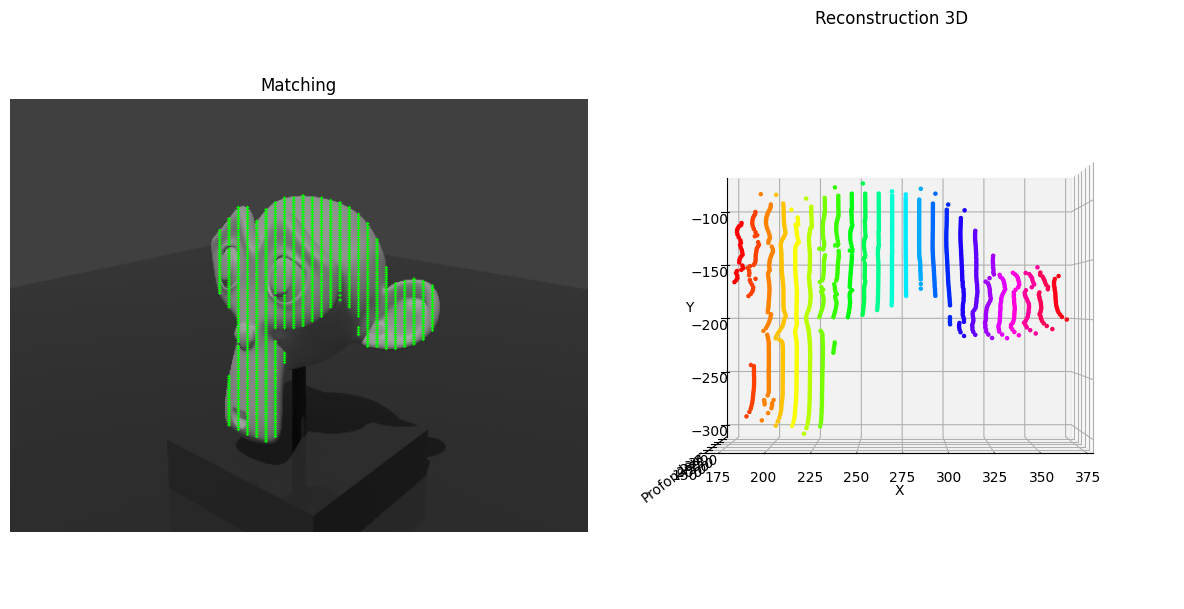

In [ ]:
import numpy as np
import cv2
import glob
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


CHECKERBOARD_SIZE = (6, 9)
def compute_fundamental_matrix(K, rvec_rel, tvec_rel):
    
    
    R, _ = cv2.Rodrigues(rvec_rel)
    
    
    tx, ty, tz = tvec_rel.flatten()
    t_skew = np.array([
        [0, -tz, ty],
        [tz, 0, -tx],
        [-ty, tx, 0]
    ], dtype=np.float32)
    
    
    E = t_skew @ R
    
    
    K_inv = np.linalg.inv(K)
    F = K_inv.T @ E @ K_inv
    
    return F

def calibrate_camera(folder_path='chessboards'):
    
    print(f"Recherche de damiers dans '{folder_path}'...")
    
    
    POSSIBLE_SIZES = [(6, 9), (9, 6), (7, 7), (7, 6), (6, 7), (10, 7), (7, 10), (5, 8), (8, 5)]
    
    images = glob.glob(f'{folder_path}/*.png')
    if not images:
        print("Erreur : Dossier vide ou chemin pas bon.")
        return np.array([[500., 0., 250.], [0., 500., 187.], [0., 0., 1.]], dtype=np.float32)

    
    found_size = None
    first_img = cv2.imread(images[0])
    if first_img is None: return np.eye(3, dtype=np.float32)
    gray_test = cv2.cvtColor(first_img, cv2.COLOR_BGR2GRAY)

    
    for size in POSSIBLE_SIZES:
        ret, _ = cv2.findChessboardCorners(gray_test, size, None)
        if ret:
            found_size = size
            print(f"Taille ytouve: {found_size}")
            break
    
    if found_size is None:
        print("Echec : Aucune taille detecte. Compte les coins mznuellement.")
        print("-> Utilisation de K defaut.")
        return np.array([[500., 0., 250.], [0., 500., 187.], [0., 0., 1.]], dtype=np.float32)

    
    objp = np.zeros((1, found_size[0] * found_size[1], 3), np.float32)
    objp[0,:,:2] = np.mgrid[0:found_size[0], 0:found_size[1]].T.reshape(-1, 2)
    
    objpoints = [] 
    imgpoints = [] 
    valid_images = 0
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

    for fname in images:
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
        ret, corners = cv2.findChessboardCorners(gray, found_size, None)
        
        if ret:
            objpoints.append(objp)
            corners2 = cv2.cornerSubPix(gray, corners, (11,11), (-1,-1), criteria)
            imgpoints.append(corners2)
            valid_images += 1
            
    print(f"Calibration reussie {valid_images} images.")
    
    if valid_images > 0:
        ret, K, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
        return K
    else:
        return np.array([[500., 0., 250.], [0., 500., 187.], [0., 0., 1.]], dtype=np.float32)

def compute_P_matrix(K, rvec, tvec):
    
    R, _ = cv2.Rodrigues(rvec)
    Rt = np.hstack((R, tvec))
    return K @ Rt

def scan_monkey(gray_img):
    
    pts = []
    colors = []
    h, w = gray_img.shape
    margin_x = int(w * 0.25)
    margin_y = int(h * 0.15)
    
    for x in range(margin_x, w - margin_x, 8):
        for y in range(margin_y, h - margin_y, 2):
            if gray_img[y, x] > 65:
                pts.append([x, y])
                colors.append(gray_img[y, x])
                
    return np.array(pts, dtype=np.float32), np.array(colors)

def main():
    
    img_path = 'main.png'
    img = cv2.imread(img_path)
    if img is None: print("Erreur : Image pas trouvee."); return
    
    img = cv2.resize(img, (500, 375))
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    
    K = calibrate_camera('chessboards')
    
    
    if 'K' not in locals() or K is None:
        K = np.array([[500., 0., 250.], [0., 500., 187.], [0., 0., 1.]], dtype=np.float32)

    
    SHIFT = 12.0
    
    
    rvec1 = np.zeros((3, 1), dtype=np.float32)
    tvec1 = np.zeros((3, 1), dtype=np.float32)
    P1 = compute_P_matrix(K, rvec1, tvec1)

    
    rvec_rel = np.zeros((3, 1), dtype=np.float32) # Pas de rotation
    tvec_rel = np.array([[0], [SHIFT], [0]], dtype=np.float32) # Juste un décalage Y
    P2 = compute_P_matrix(K, rvec_rel, tvec_rel)

    
    F = compute_fundamental_matrix(K, rvec_rel, tvec_rel)
    print("\n--- Matrice Fondamentale (F) ---")
    print(F)

    
    pts1, colors = scan_monkey(gray)
    if len(pts1) == 0: print("pas de pts scanne."); return

    
    
    p1 = np.array([pts1[0][0], pts1[0][1], 1.0])          
    p2 = np.array([pts1[0][0], pts1[0][1] + SHIFT, 1.0])  
    
    error = np.abs(p2.T @ F @ p1)
    print(f"Verifi épipolaire (Erreur doit etre proche de 0) : {error:.5f}")
    print("--------------------------------\n")

    
    pts2 = pts1.copy()
    pts2[:, 1] += SHIFT 

    
    points_4d = cv2.triangulatePoints(P1, P2, pts1.T, pts2.T)
    points_3d = points_4d[:3, :] / points_4d[3, :]
    points_3d = points_3d.T
    
    
    X = pts1[:, 0]
    Y = pts1[:, 1]
    Z_visual = colors * 2.5 

    
    fig = plt.figure(figsize=(12, 6))
    
    ax1 = fig.add_subplot(1, 2, 1)
    img_display = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    for pt in pts1:
        cv2.circle(img_display, tuple(np.int32(pt)), 1, (0, 255, 0), -1)
    ax1.imshow(img_display)
    ax1.set_title("Matching")
    ax1.axis('off')

    ax2 = fig.add_subplot(1, 2, 2, projection='3d')
    sc = ax2.scatter(X, Z_visual, -Y, c=X, cmap='hsv', s=5, alpha=1)
    ax2.set_xlabel('X')
    ax2.set_ylabel('Profondeur')
    ax2.set_zlabel('Y')
    ax2.set_title("Reconstruction 3D")
    ax2.view_init(elev=0, azim=-90)
    
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()